<a href="https://colab.research.google.com/github/1900690/yolov10/blob/main/train-yolov10-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# カスタムデータセットでYOLOv10の物体検出をトレーニングする方法

---

[![arXiv](https://img.shields.io/badge/arXiv-2405.14458-b31b1b.svg)](https://arxiv.org/pdf/2405.14458.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yolov10)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/YOLO-ARENA)

YOLOv10は、リアルタイムでエンドツーエンドの物体検出を行うYOLOシリーズの新世代です。非最大抑制（NMS）の必要性をなくし、モデル・アーキテクチャを包括的に最適化することで、YOLOの性能と効率の両方を向上させることを目的としています。この進歩により、計算オーバーヘッドが削減され、効率と能力の両方が向上します。YOLOv10は最先端の性能と効率を示し、YOLOv10-SはRT-DETR-R18より1.8倍高速で、パラメータとFLOP数が大幅に少ない。さらに、YOLOv10-Bは、同じ性能を維持しながら、YOLOv9-Cと比較してレイテンシを46%削減し、パラメータを25%削減しています。

<p align="center">
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_latency.svg" width=48%>
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_params.svg" width=48%> <br>
  Comparisons with others in terms of latency-accuracy (left) and size-accuracy (right) trade-offs.
</p>

## Pro Tip: GPUアクセラレーションを使う

Google Colabでこのノートブックを実行している場合、`Edit` -> `Notebook settings` -> `Hardware accelerator` に移動し、`GPU`に設定し、`Save`をクリックします。これでノートブックがGPUを使用するようになり、モデルのトレーニング時間が大幅に短縮されます。

## このチュートリアルのステップ

このチュートリアルでは、以下を取り上げます：

- 始める前に
- YOLOv10をインストールする
- 訓練済み重みのダウンロード
- サンプルデータのダウンロード
- 学習済みCOCOモデルによる推論
- Roboflow Universeからデータセットをダウンロードする
- カスタムトレーニング
- カスタムモデルの検証
- カスタムモデルによる推論

## 始める前に

GPUにアクセスできることを確認しよう。nvidia-smi`コマンドを使うことができる。問題があれば、`ランタイム` -> `ランタイムのタイプを変更` に移動し、`GPU`に設定し、`保存`をクリックする。

In [1]:
#GPUに接続しているか確認
!nvidia-smi

Sun Jun 16 13:38:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#カレントディレクトリの確認とインストール場所の設定
import os
HOME = os.getcwd()
print(HOME)

/content


## YOLOv10をインストールする

**注意：**現在、YOLOv10は独自のPyPIパッケージを持っていない。そのため、ソースからインストールする必要がある。

In [3]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.1 MB/s eta 0:00:00


**注:** 2つの追加パッケージもインストールする： [Roboflowユニバース](https://universe.roboflow.com/)からデータセットをダウンロードするための[`roboflow`](https://github.com/roboflow/roboflow-python)と、結果を可視化するための[`supervision`](https://github.com/roboflow/supervision)です。

In [4]:
!pip install -q supervision roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76


## 訓練済み重みのダウンロード

**注:** YOLOv10は、COCOデータセットで事前にトレーニングされたウェイトファイルを様々なサイズで提供しています。ダウンロードしてみよう。

In [5]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


## サンプルデータのダウンロード

**注:**画像をダウンロードしてみましょう。画像や動画はご自由にお使いください。

In [6]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh {HOME}/data

total 104K
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg


## 訓練済みCOCOモデルによる推論

**注:** YOLOv10はYOLOv8をベースにしており、YOLOv8と同様、CLIモードとSDKモードの両方で使用できる。

### 💻 CLI

In [7]:
#サンプル画像で推論してみる
%cd {HOME}

!yolo task=detect mode=predict conf=0.25 save=True \
model={HOME}/weights/yolov10n.pt \
source={HOME}/data/dog.jpeg

/content
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2762608 parameters, 63840 gradients, 8.6 GFLOPs

image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 dog, 97.5ms
Speed: 3.5ms preprocess, 97.5ms inference, 403.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**注:** 結果を表示しましょう。

/content


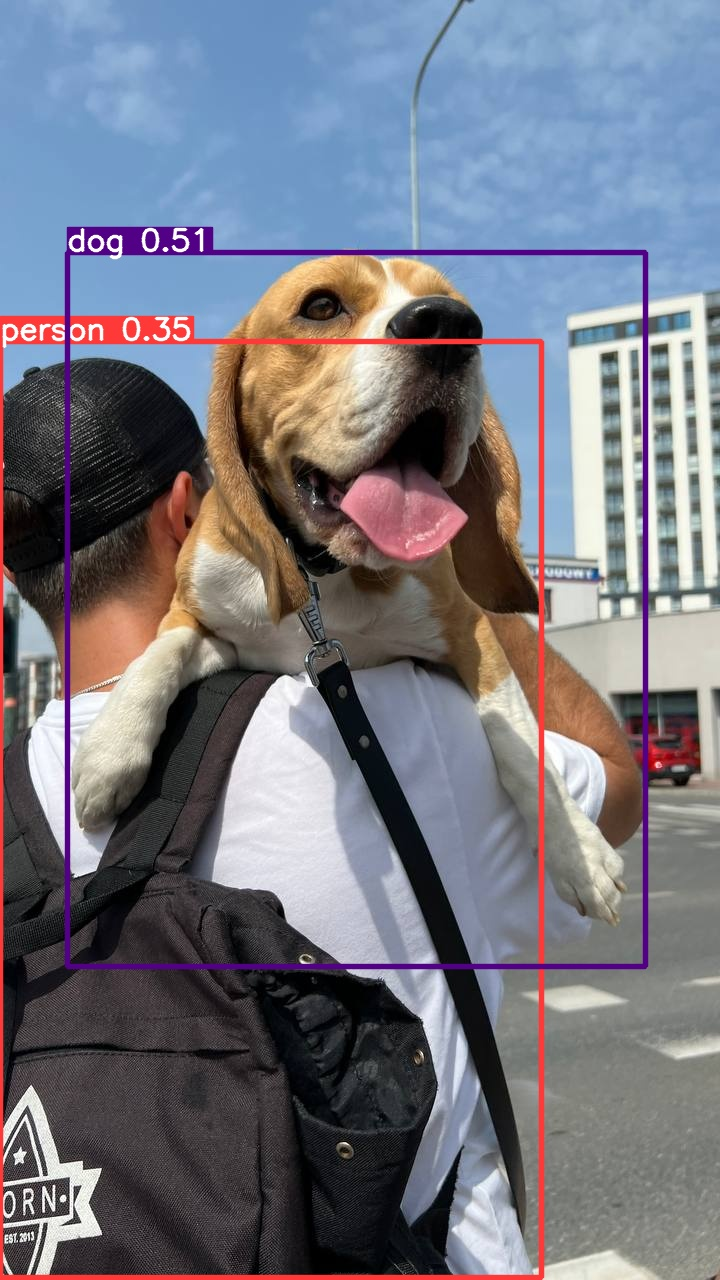

In [8]:
%cd {HOME}

from IPython.display import Image

Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

In [9]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
results = model(source=f'{HOME}/data/dog.jpeg', conf=0.25)


image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 dog, 169.2ms
Speed: 7.1ms preprocess, 169.2ms inference, 212.4ms postprocess per image at shape (1, 3, 640, 384)


In [10]:
results[0].boxes.xyxy

tensor([[6.7041e+01, 2.5264e+02, 6.4549e+02, 9.6621e+02],
        [7.4646e-01, 3.4156e+02, 5.4170e+02, 1.2773e+03]], device='cuda:0')

In [11]:
results[0].boxes.conf

tensor([0.5090, 0.3536], device='cuda:0')

In [12]:
results[0].boxes.cls

tensor([16.,  0.], device='cuda:0')

**注:** `supervision`を使って結果を表示してみよう。


0: 640x384 1 person, 1 dog, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


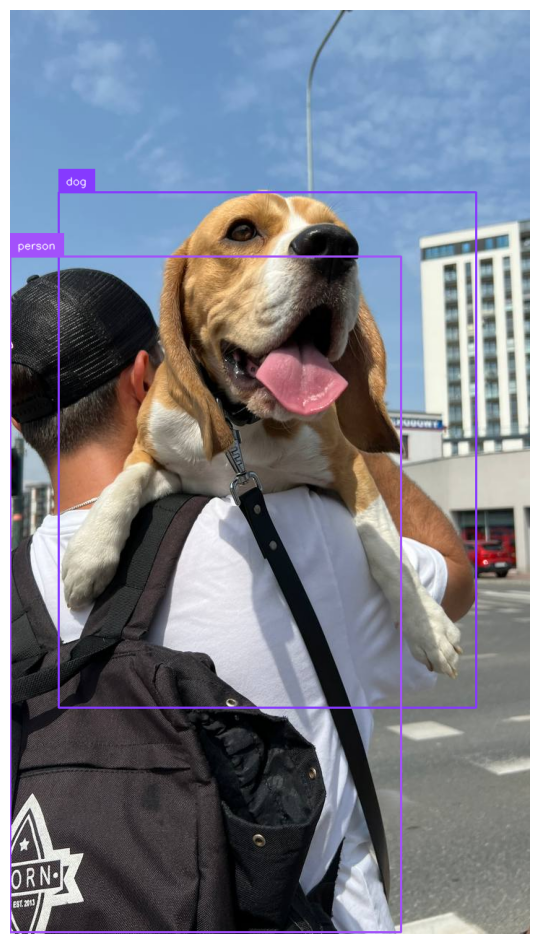

In [13]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
image = cv2.imread(f'{HOME}/data/dog.jpeg')
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Roboflow Universeからデータセットをダウンロードする

データセットは[脳の腫瘍の画像データ](https://universe.roboflow.com/selencakmak/tumor-dj2a1)で、`test、train、valid`の三つのフォルダと`data.yaml`のセットである





In [16]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

#ROBOFLOW_API_KEYを持って左のカギマークから新しいシークレットを追加で追加する
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("selencakmak").project("tumor-dj2a1")
version = project.version(1)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Tumor-1 in yolov8:: 100%|██████████| 3006/3006 [00:00<00:00, 5219.40it/s]


**注：**
data.yamlファイルの最後の3行が以下の形式であることを確認してください、異なる場合は以下の形式に書き換えてください

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

Roboflow Universeのデータセットを使用する場合は、以下のコマンドを実行してください。👇🏻

In [ ]:
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

## カスタムトレーニング

In [17]:
%cd {HOME}

!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.32 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/datasets/Tumor-1/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, r

In [18]:
#学習後のフォルダに何があるか確認
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1718547079.74ac4e0643b5.9175.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


/content


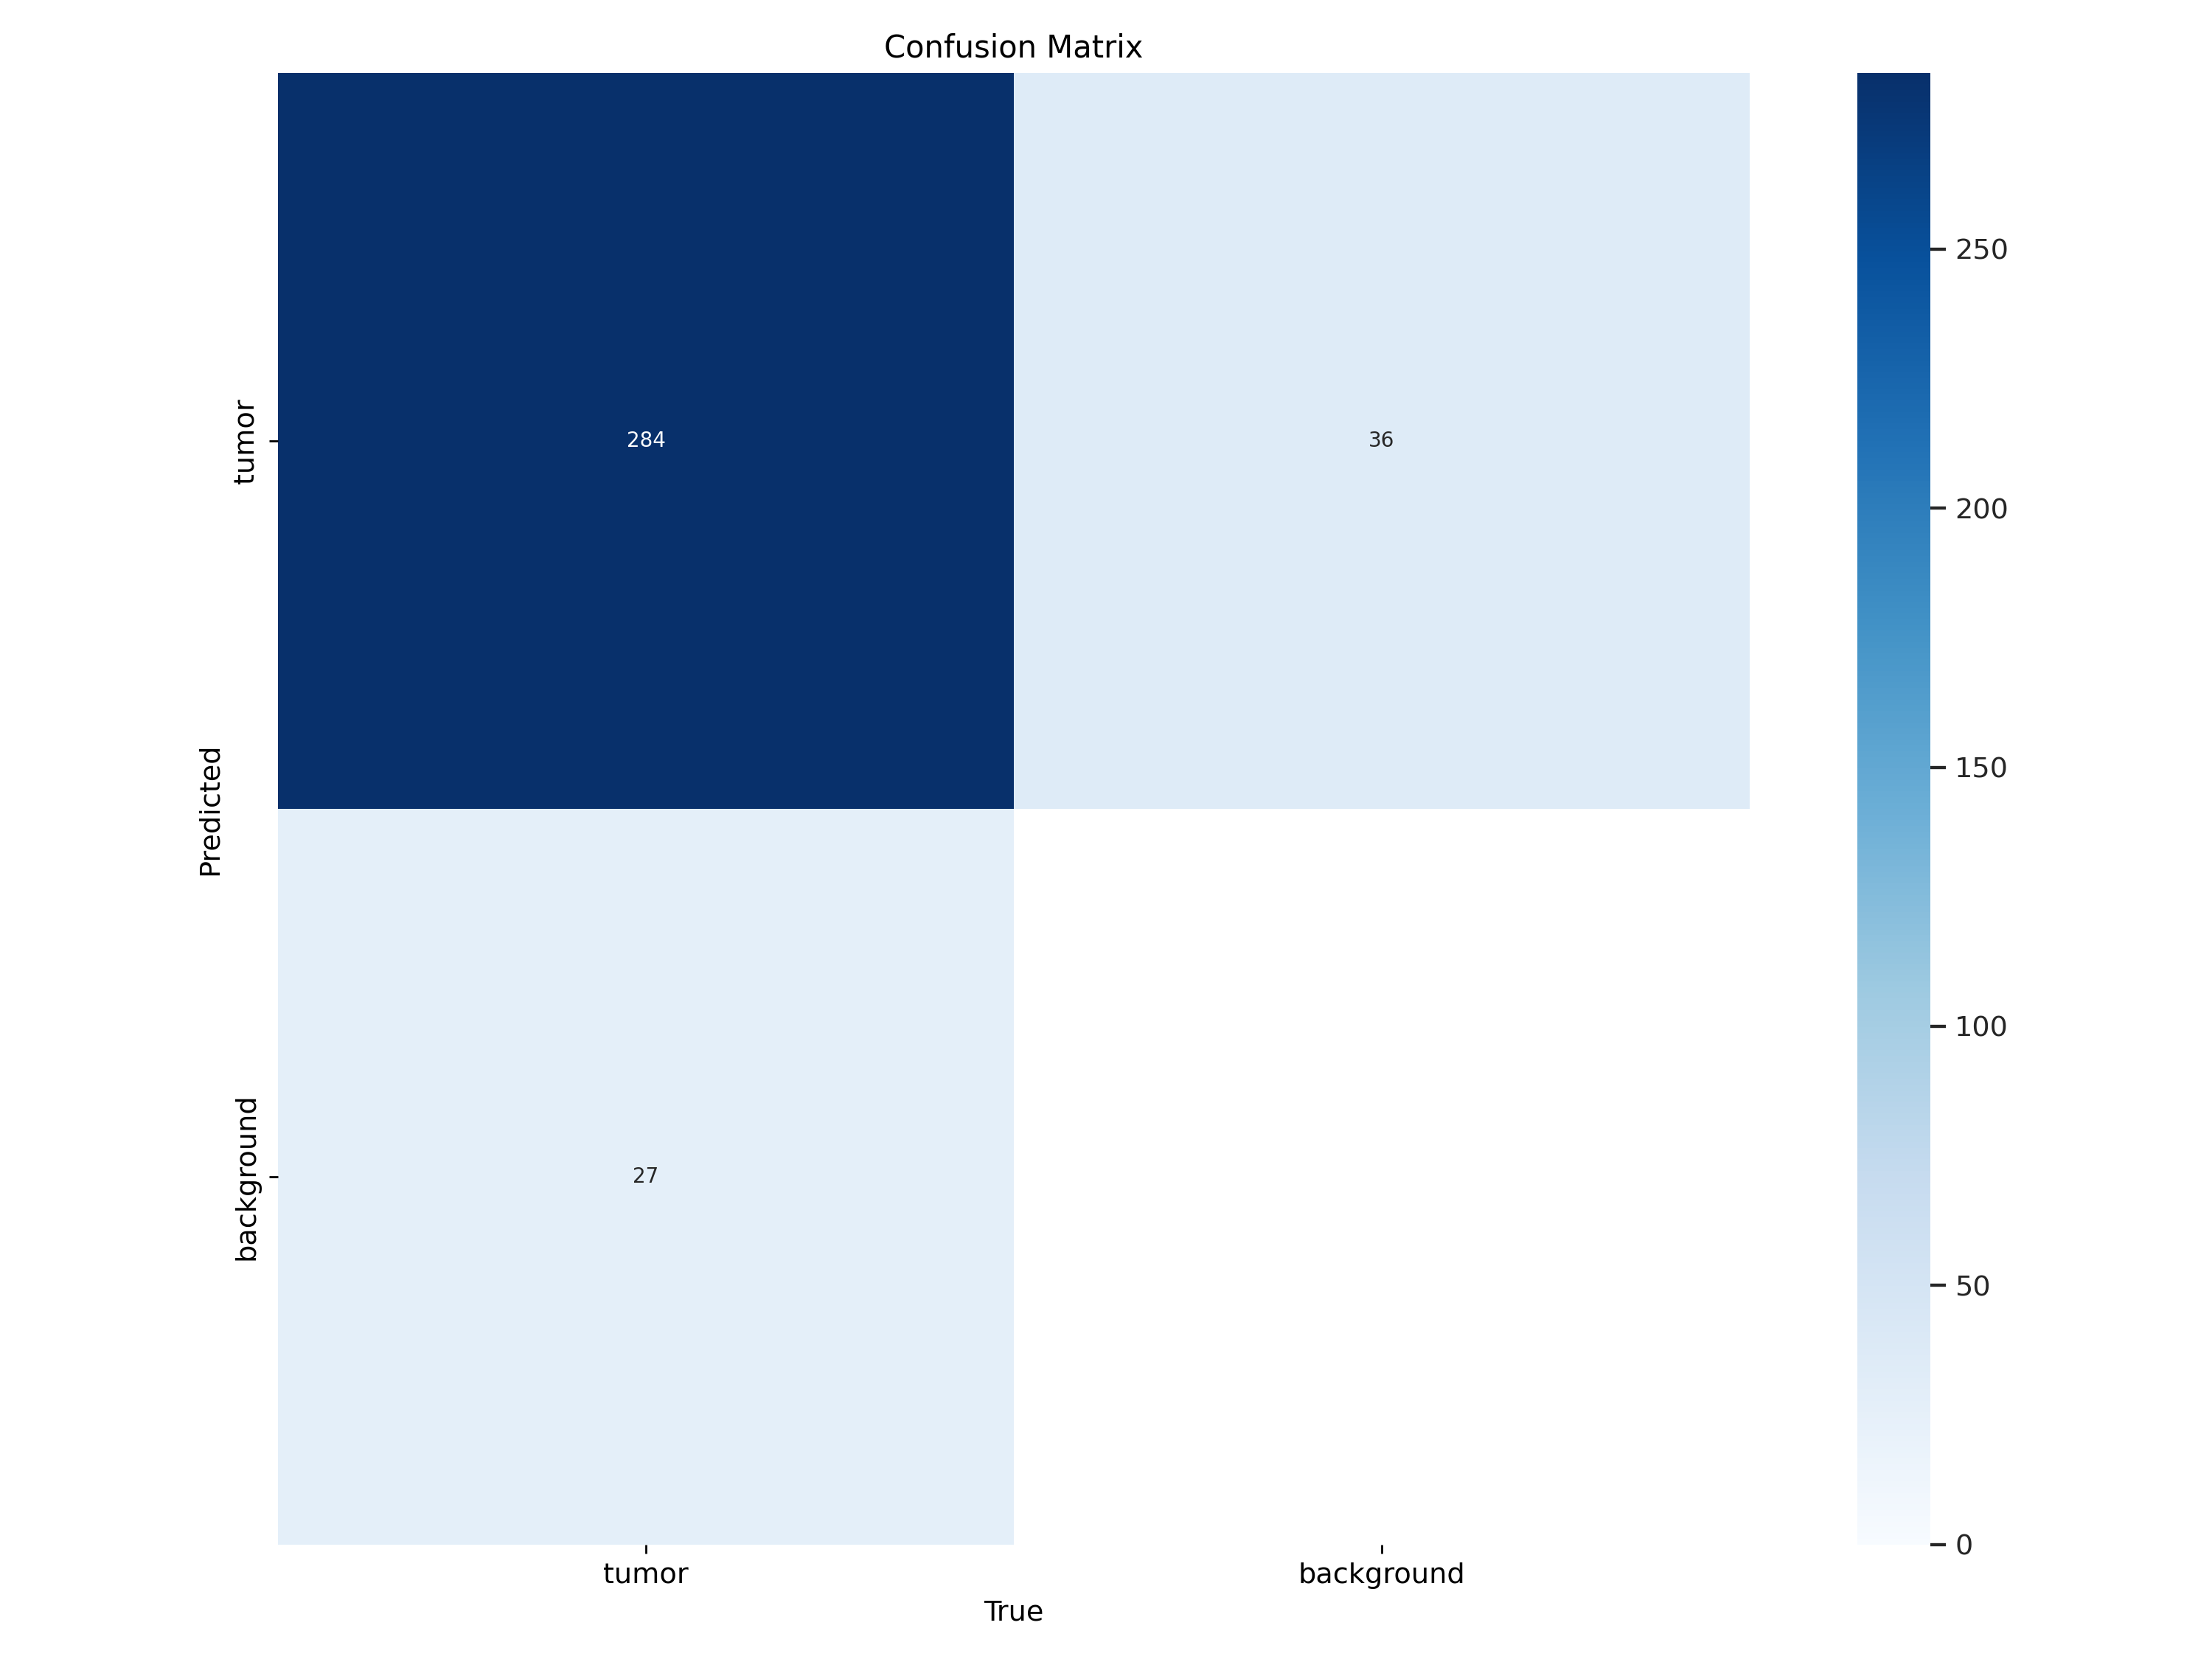

In [19]:
#confusionマトリックスを表示
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


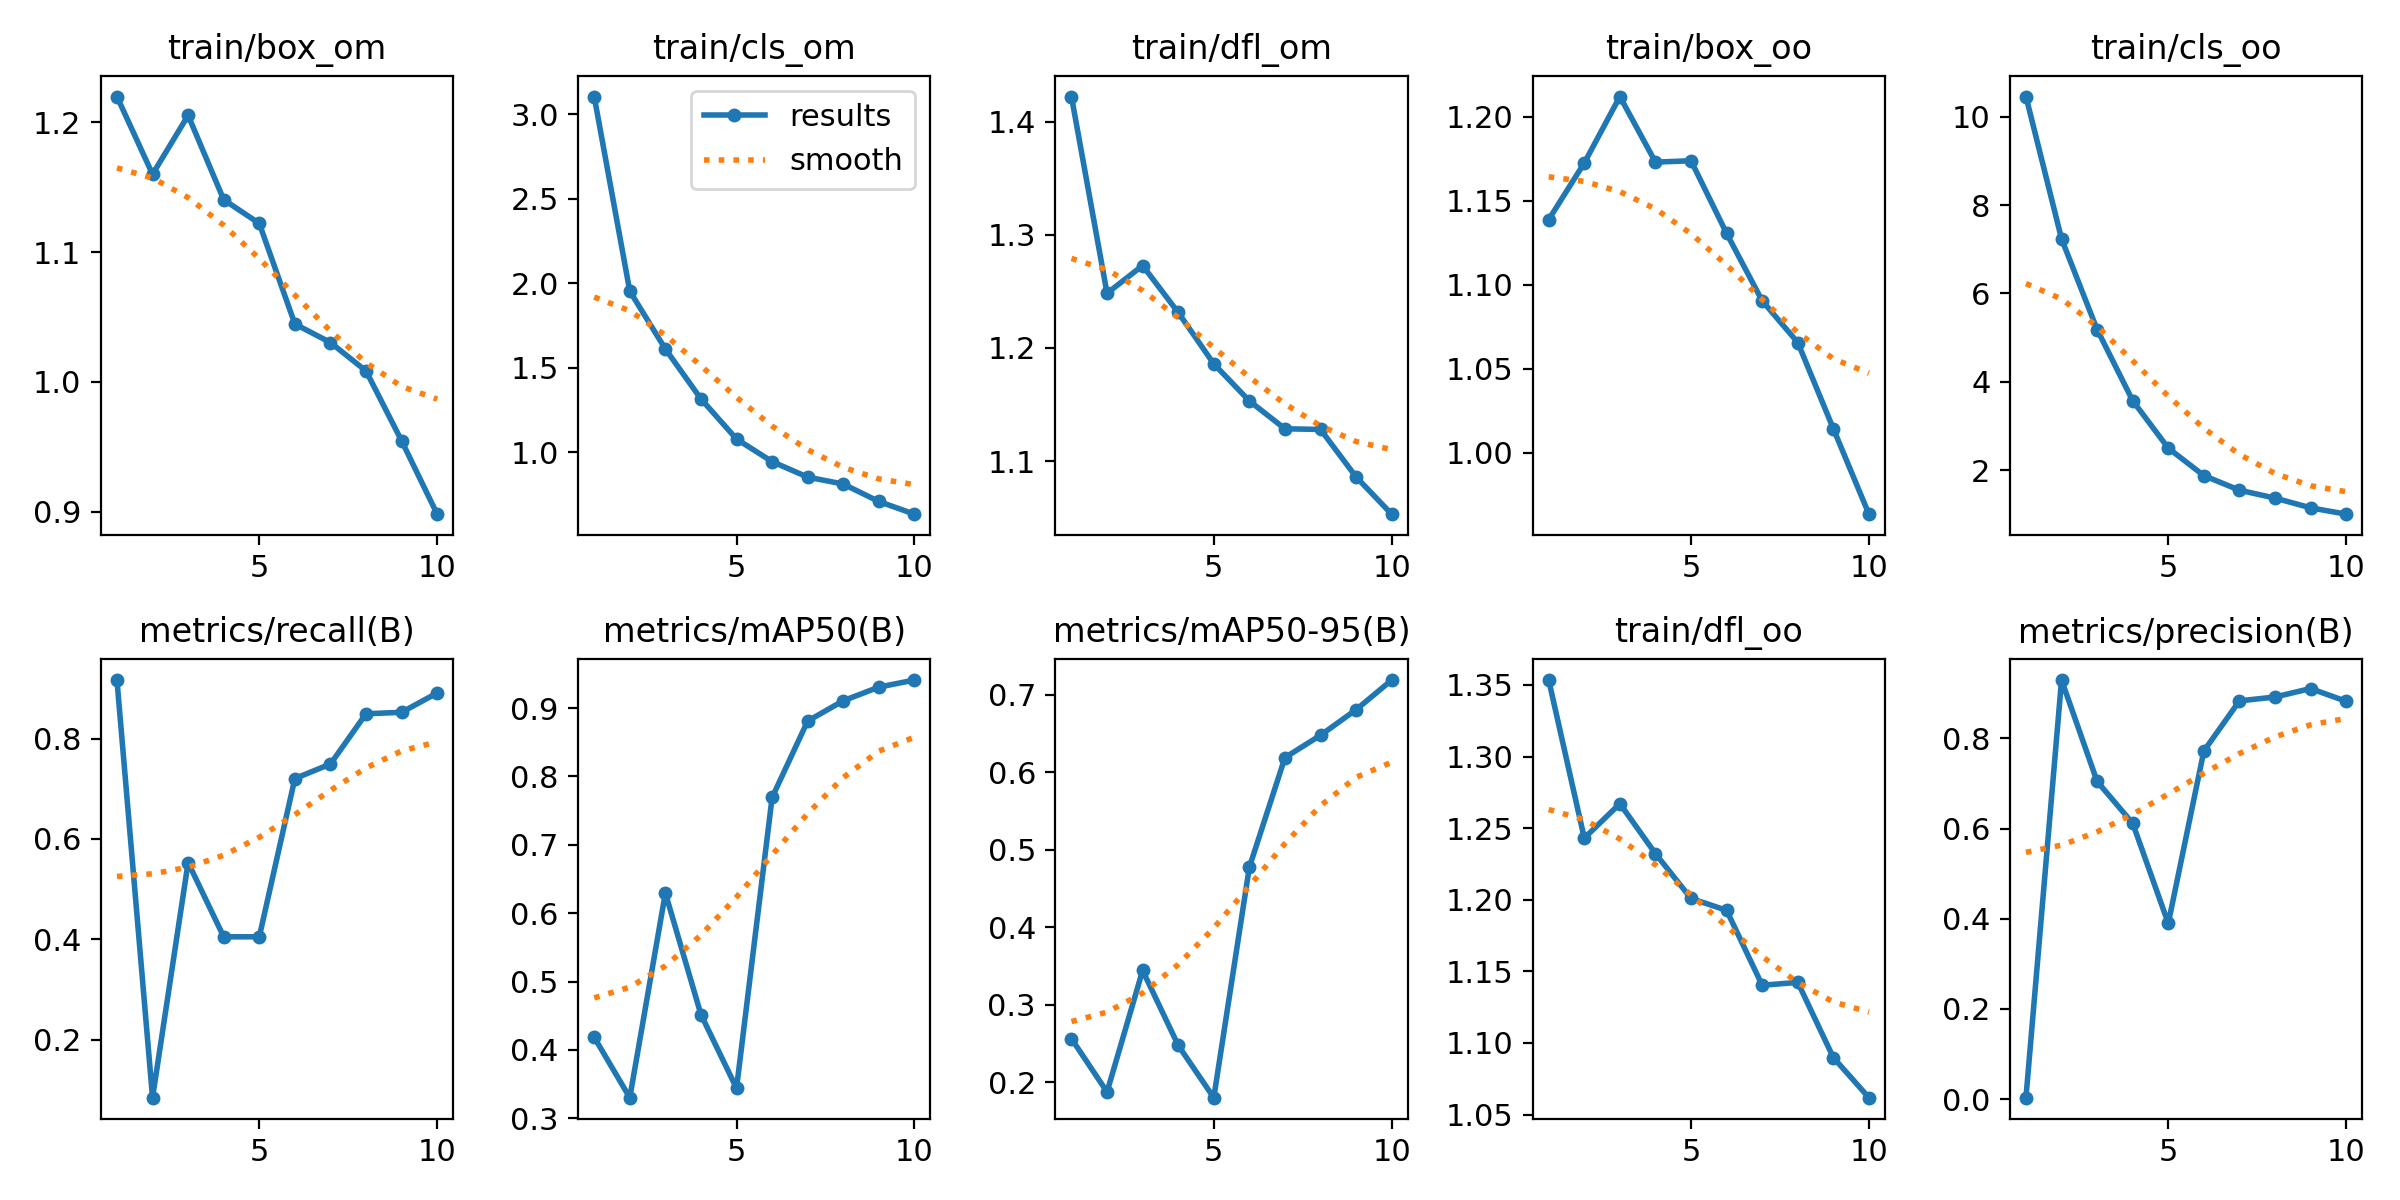

In [20]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## カスタムモデルによる推論

**注:**新しく学習したモデルをロードすることから始めましょう。

In [21]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

**注：**検証セットからランダムに画像を選択し、結果を視覚化してみましょう。


0: 640x640 1 tumor, 14.5ms
Speed: 3.1ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


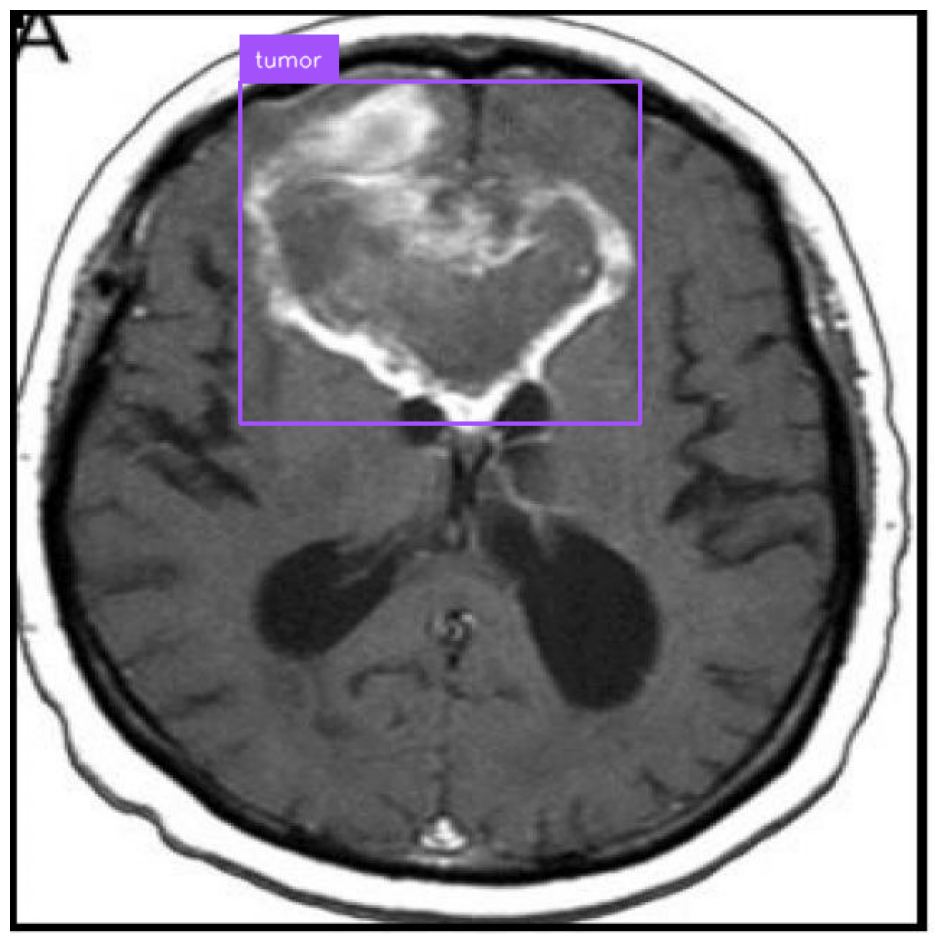

In [23]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)